In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
from hashlib import sha256
import os
import json

In [91]:
def str_to_bytes(string):
    return string.encode('utf-8')

def int_to_bytes(x):
    return x.to_bytes(blocksize, order)

def bytes_to_int(x_bytes):
    return int.from_bytes(x_bytes, order)

def hmac_sha256(key, data):
    k_xor_opad, k_xor_ipad = bytearray(), bytearray()
    if len(key) < blocksize:
        key = zero_byte.to_bytes(blocksize-len(key), order) + key
    for i in range(blocksize):
        k_xor_opad.append(key[i] ^ 0x5c)
        k_xor_ipad.append(key[i] ^ 0x36)
    return sha256(k_xor_opad + sha256(k_xor_ipad + data).digest()).digest()

def extract_first_5_bits_from_key(key, lower_bound, upper_bound):
    return int('{:08b}'.format(key[0])[lower_bound:upper_bound], 2)

In [6]:
order = 'big' # big endian
blocksize = 64
zero_byte = 0
hmac_size =  32
lower_bound, upper_bound = 3, 8

In [60]:
def F(password, salt, number_of_iterations, i):
    """
    в result_of_xor последовательно накапливается xor вычисленных u
    в u_prev последнее вычисленное u
    """
    result_of_xor = u_prev = hmac_sha256(password, salt + int_to_bytes(i))
    for _ in range(number_of_iterations - 1):
        u_prev = hmac_sha256(password, u_prev)
        new_result_of_xor = bytearray()  
        for i in range(hmac_size):
            new_result_of_xor.append(result_of_xor[i] ^ u_prev[i])
        result_of_xor = new_result_of_xor
    return result_of_xor

def generate_pbkf2_key(password, salt, number_of_iterations, key_length):
    k = bytes()
    for i in range(1, (key_length // hmac_size) + 1):
        Ti = F(password, salt, number_of_iterations, i)
        k += Ti
    return k

In [67]:
path_to_passwords_json = "passwords.json"
with open(path_to_passwords_json, 'r') as file:
    passwords = json.load(file)

In [69]:
passwords_bytes = [str_to_bytes(password) for password in passwords]

In [85]:
salt = os.urandom(blocksize)
number_of_iterations = 1000
key_length = 512

Получение ключей длины 512 байт для каждого из пароля в файле:

In [86]:
%%time
secure_keys = [generate_pbkf2_key(password, salt, number_of_iterations, key_length) for password in passwords_bytes]

CPU times: user 11min 22s, sys: 2.87 s, total: 11min 24s
Wall time: 11min 37s


In [92]:
first_bits_of_secure_keys = [extract_first_5_bits_from_key(key, lower_bound, upper_bound) 
                           for key in secure_keys]

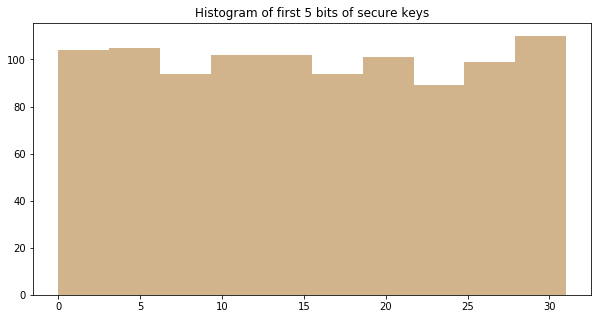

In [99]:
plt.figure(figsize=(10,5))
plt.title('Histogram of first 5 bits of secure keys') 
plt.hist(first_bits_of_secure_keys, bins=10, color='tan')
plt.savefig('hists/5_bits_secure_keys')

Полученное распределение похоже на равномерное.